In [ ]:
# Importing essential libraries for data processing, computer vision, NLP, and machine learning tasks

import os
import json
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import requests
from zipfile import ZipFile
import os
import cv2
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from PIL import Image
import os
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tqdm import tqdm
import requests
from google.colab import drive
import shutil

Mounted at /content/drive
Step 1: Downloading complete dataset to Google Drive...

Checking Google Drive for existing dataset...

Complete dataset found in Google Drive. Skipping download.

Enter the number of samples to extract (e.g., 100): 100

Step 2: Extracting 100 samples...

Extracting samples from Google Drive dataset...

Extracting 100 images...


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]



Extracted:
Number of Images: 100
Number of Questions: 575
Number of Annotations: 575
Average Questions per Image: 5.8

Dataset Statistics:
Number of Questions: 575
Number of Annotations: 575

Enter the number of samples to visualize (e.g., 5): 5

Visualizing 5 random samples...


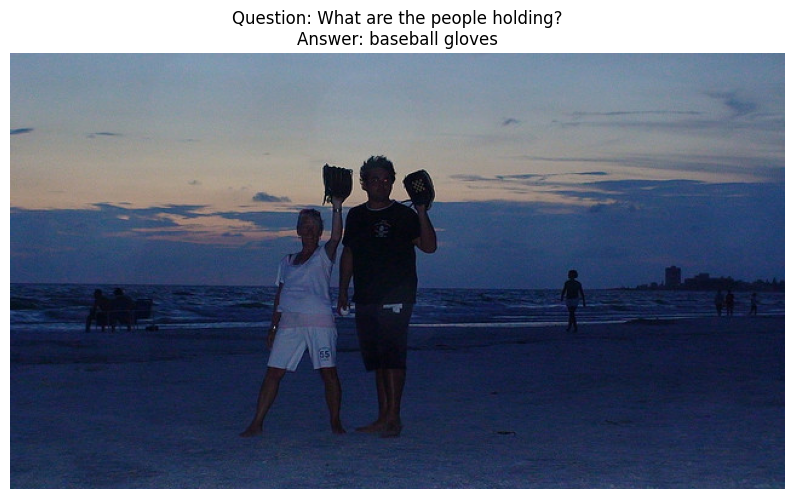

Image ID: 179460
Question ID: 179460000
Question Type: what are the
Answer Type: other
All Answers: ['baseball glove', 'gloves', 'baseball gloves', 'baseball gloves', 'shell', 'baseball mitt', 'bags', 'baseball glove', 'mitts', 'baseball gloves']
--------------------------------------------------


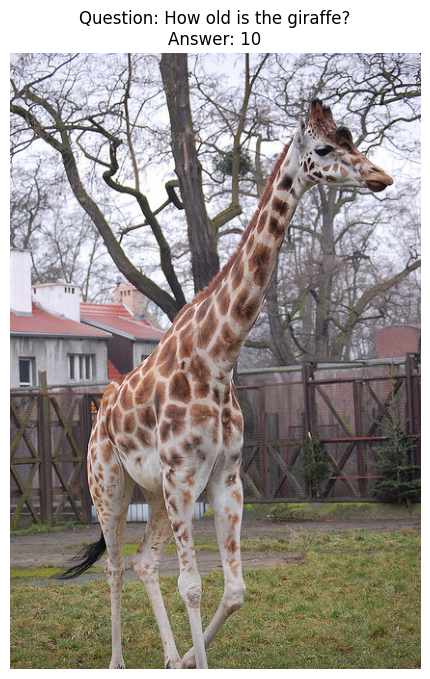

Image ID: 564707
Question ID: 564707002
Question Type: how
Answer Type: number
All Answers: ['10', 'young', "i don't know", '5', '7 years old', '3', '1 yr', '3', '1', '10']
--------------------------------------------------


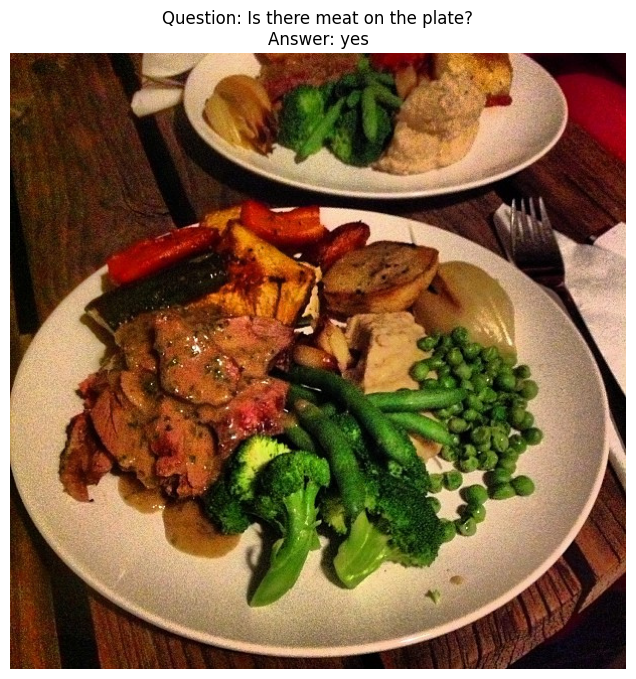

Image ID: 393488
Question ID: 393488003
Question Type: is there
Answer Type: yes/no
All Answers: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
--------------------------------------------------


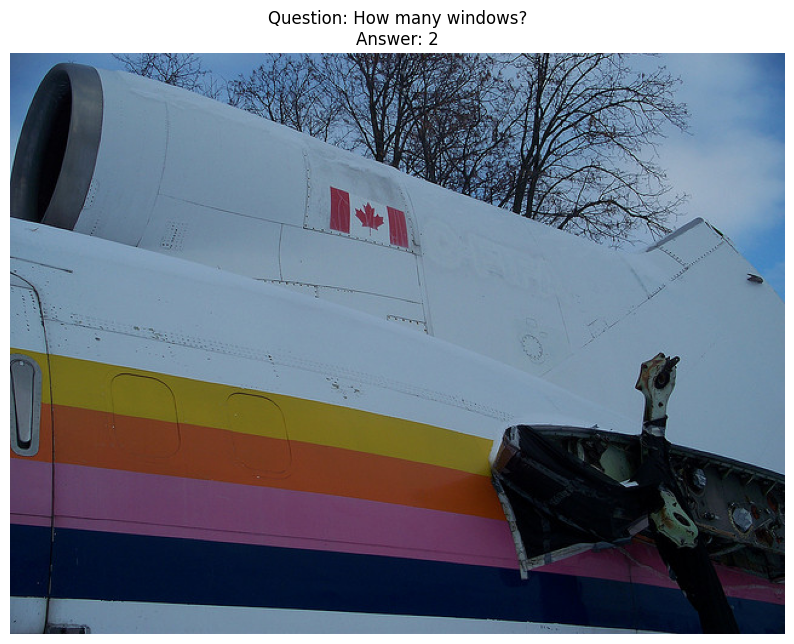

Image ID: 242153
Question ID: 242153000
Question Type: how many
Answer Type: number
All Answers: ['0', '0', '2', '1', '2', '1', '2', '2', '2', '0']
--------------------------------------------------


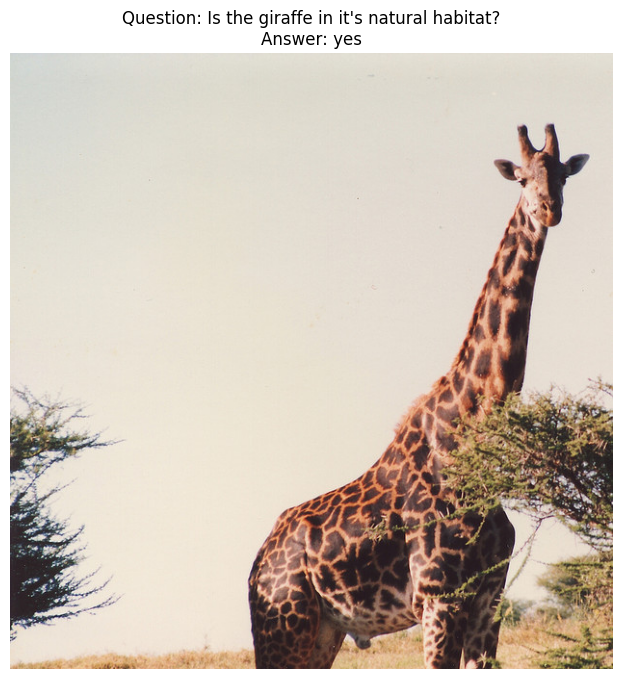

Image ID: 562389
Question ID: 562389003
Question Type: is the
Answer Type: yes/no
All Answers: ['yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
--------------------------------------------------

Do you want to clean up local files? (y/n): y

Local files cleaned up


In [ ]:
#This code block downloads, extracts, and processes the VQA dataset, helps for sample visualization and cleanup.
# It integrates with Google Drive for storage.

class VQADataDownloader:
    def __init__(self):
        """Initialize the VQA data downloader with Google Drive integration"""

        drive.mount('/content/drive')


        self.gdrive_dir = "/content/drive/MyDrive/VQA_Dataset"
        self.local_dir = "/content/vqa_dataset"


        os.makedirs(self.gdrive_dir, exist_ok=True)
        os.makedirs(self.local_dir, exist_ok=True)


        self.questions_path = os.path.join(self.local_dir, 'v2_OpenEnded_mscoco_train2014_questions.json')
        self.annotations_path = os.path.join(self.local_dir, 'v2_mscoco_train2014_annotations.json')
        self.images_dir = os.path.join(self.local_dir, 'train2014')

    def download_file(self, url, dest_path):
        """Download file with progress bar"""
        print(f"\nDownloading to: {dest_path}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(dest_path, 'wb') as file, tqdm(
            desc=os.path.basename(dest_path),
            total=total_size,
            unit='iB',
            unit_scale=True
        ) as pbar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                pbar.update(size)

    def download_complete_dataset(self):
        """Check for dataset in Google Drive and download only if missing"""
        print("\nChecking Google Drive for existing dataset...")

        required_files = ['questions.zip', 'annotations.zip', 'images.zip']
        all_files_exist = all(
            os.path.exists(os.path.join(self.gdrive_dir, file))
            for file in required_files
        )

        if all_files_exist:
            print("\nComplete dataset found in Google Drive. Skipping download.")
            return


        print("\nSome files missing. Downloading required files...")
        urls = {
            'questions': "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip",
            'annotations': "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip",
            'images': "http://images.cocodataset.org/zips/train2014.zip"
        }

        for name, url in urls.items():
            gdrive_path = os.path.join(self.gdrive_dir, f"{name}.zip")
            if not os.path.exists(gdrive_path):
                print(f"\nDownloading {name} dataset...")
                self.download_file(url, gdrive_path)
                print(f"Saved {name} to Google Drive")
            else:
                print(f"\n{name.capitalize()} already exists in Google Drive")

        print("\nComplete dataset available in Google Drive")

    def extract_samples(self, num_samples):
        """Extract specified number of samples from Google Drive dataset, including all questions per image"""
        print("\nExtracting samples from Google Drive dataset...")

        for name in ['questions', 'annotations']:
            gdrive_path = os.path.join(self.gdrive_dir, f"{name}.zip")
            with ZipFile(gdrive_path, 'r') as zip_ref:
                zip_ref.extractall(self.local_dir)


        with open(self.questions_path, 'r') as f:
            questions = json.load(f)
        with open(self.annotations_path, 'r') as f:
            annotations = json.load(f)


        questions_by_image = {}
        for q in questions['questions']:
            if q['image_id'] not in questions_by_image:
                questions_by_image[q['image_id']] = []
            questions_by_image[q['image_id']].append(q)


        all_image_ids = list(questions_by_image.keys())
        selected_image_ids = random.sample(all_image_ids, min(num_samples, len(all_image_ids)))


        filtered_questions = []
        for img_id in selected_image_ids:
            filtered_questions.extend(questions_by_image[img_id])


        question_id_to_annotation = {a['question_id']: a for a in annotations['annotations']}
        filtered_annotations = [question_id_to_annotation[q['question_id']] for q in filtered_questions]


        required_files = {f"COCO_train2014_{img_id:012d}.jpg" for img_id in selected_image_ids}

        if not os.path.exists(self.images_dir):
            os.makedirs(self.images_dir)

        images_zip = os.path.join(self.gdrive_dir, "images.zip")
        print(f"\nExtracting {len(required_files)} images...")

        with ZipFile(images_zip, 'r') as zip_ref:
            all_files = zip_ref.namelist()
            files_to_extract = [f for f in all_files if f.split('/')[-1] in required_files]

            for file in tqdm(files_to_extract):
                zip_ref.extract(file, self.local_dir)

        print(f"\nExtracted:")
        print(f"Number of Images: {len(selected_image_ids)}")
        print(f"Number of Questions: {len(filtered_questions)}")
        print(f"Number of Annotations: {len(filtered_annotations)}")
        print(f"Average Questions per Image: {len(filtered_questions)/len(selected_image_ids):.1f}")

        return filtered_questions, filtered_annotations

    def visualize_samples(self, questions, annotations, num_display=5):
        """Visualize random samples from the dataset"""
        indices = random.sample(range(len(questions)), min(num_display, len(questions)))

        for idx in indices:
            question = questions[idx]
            annotation = annotations[idx]

            image_path = os.path.join(self.images_dir, f"COCO_train2014_{question['image_id']:012d}.jpg")
            image = Image.open(image_path)

            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Question: {question['question']}\nAnswer: {annotation['multiple_choice_answer']}")
            plt.show()
            print(f"Image ID: {question['image_id']}")
            print(f"Question ID: {question['question_id']}")
            print(f"Question Type: {annotation['question_type']}")
            print(f"Answer Type: {annotation['answer_type']}")
            print("All Answers:", [ans['answer'] for ans in annotation['answers']])
            print("-" * 50)

    def cleanup(self):
        """Clean up local files"""
        if os.path.exists(self.local_dir):
            shutil.rmtree(self.local_dir)
        print("\nLocal files cleaned up")

if __name__ == "__main__":
    downloader = VQADataDownloader()

    print("Step 1: Downloading complete dataset to Google Drive...")
    downloader.download_complete_dataset()

    num_samples = int(input("\nEnter the number of samples to extract (e.g., 100): "))

    print(f"\nStep 2: Extracting {num_samples} samples...")
    questions, annotations = downloader.extract_samples(num_samples)

    print(f"\nDataset Statistics:")
    print(f"Number of Questions: {len(questions)}")
    print(f"Number of Annotations: {len(annotations)}")

    num_display = int(input("\nEnter the number of samples to visualize (e.g., 5): "))
    print(f"\nVisualizing {num_display} random samples...")
    downloader.visualize_samples(questions, annotations, num_display)

    cleanup_response = input("\nDo you want to clean up local files? (y/n): ")
    if cleanup_response.lower() == 'y':
        downloader.cleanup()



Step 3: Visualizing the distribution of question types...


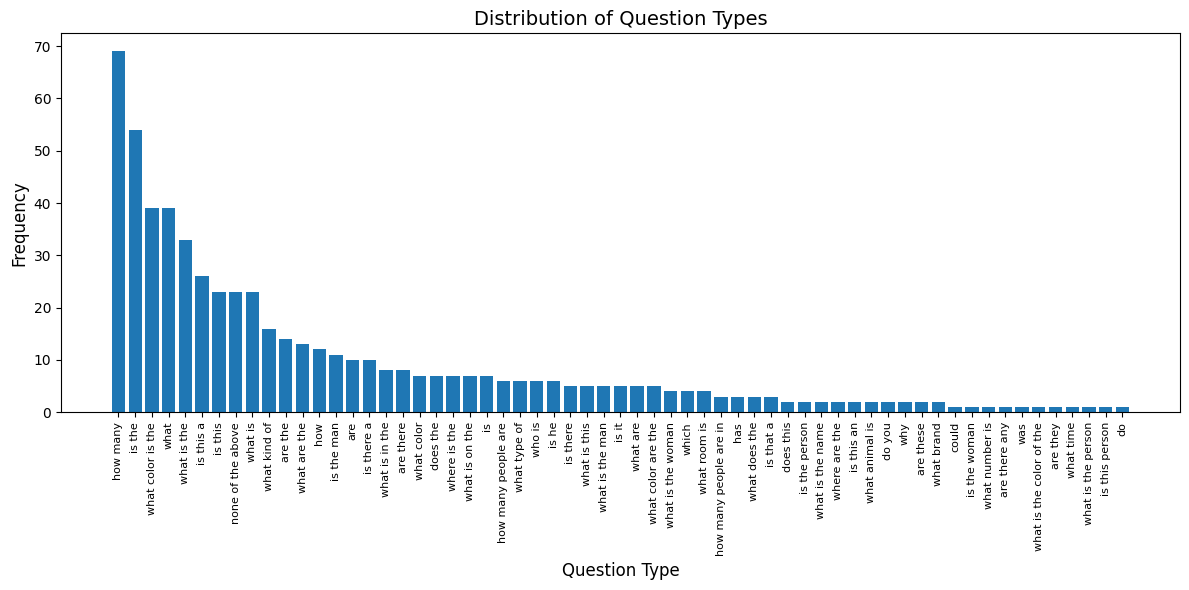

In [ ]:
# This code block visualizes the distribution of question types in a dataset by extracting their frequencies from annotations and plotting them as a bar chart.
# It helps identify the most common question types, aiding in understanding the dataset's composition.

import matplotlib.pyplot as plt
from collections import Counter

def plot_question_type_distribution(annotations):
    """Visualize the distribution of question types in the dataset."""

    question_types = [annotation['question_type'] for annotation in annotations]

    question_type_counts = Counter(question_types)

    sorted_question_types = sorted(question_type_counts.items(), key=lambda x: x[1], reverse=True)
    types, counts = zip(*sorted_question_types)

    plt.figure(figsize=(12, 6))
    plt.bar(types, counts)
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Question Type", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of Question Types", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("\nStep 3: Visualizing the distribution of question types...")
    plot_question_type_distribution(annotations)


In [ ]:
# The code defines a VQAProcessor class to preprocess images, tokenize questions, and create train, validation,
# and test datasets for Visual Question Answering (VQA) tasks with proper error handling and data saving

import os
import cv2
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from PIL import Image

class VQAProcessor:
    def __init__(self, dataset_dir, max_samples=500):
        self.dataset_dir = dataset_dir
        self.max_samples = max_samples

        self.questions_path = os.path.join(dataset_dir, 'v2_OpenEnded_mscoco_train2014_questions.json')
        self.annotations_path = os.path.join(dataset_dir, 'v2_mscoco_train2014_annotations.json')
        self.images_dir = os.path.join(dataset_dir, 'train2014')
        self.processed_img_dir = os.path.join(dataset_dir, 'processed_images')

        os.makedirs(self.processed_img_dir, exist_ok=True)

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def preprocess_image(self, image_path, size=(224, 224)):
        """Preprocess a single image with better error handling"""
        try:
            image = Image.open(image_path).convert('RGB')
            image = image.resize(size)
            image_array = np.array(image)
            image_normalized = image_array.astype(np.float32) / 255.0
            return image_normalized
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            return None

    def preprocess_images_batch(self, image_ids):
        """Preprocess a batch of images with validation"""
        print("\nPreprocessing images...")
        processed_images = {}
        valid_image_ids = []

        for img_id in tqdm(image_ids, desc="Processing Images"):
            if pd.isna(img_id):
                continue

            input_path = os.path.join(self.images_dir, f"COCO_train2014_{int(img_id):012d}.jpg")
            output_path = os.path.join(self.processed_img_dir, f"COCO_train2014_{int(img_id):012d}.npy")

            if os.path.exists(output_path):
                processed_images[img_id] = output_path
                valid_image_ids.append(img_id)
            else:
                processed_img = self.preprocess_image(input_path)
                if processed_img is not None:
                    np.save(output_path, processed_img)
                    processed_images[img_id] = output_path
                    valid_image_ids.append(img_id)

        return processed_images, valid_image_ids

    def tokenize_questions(self, questions):
        """Tokenize questions with tensor conversion"""
        print("\nTokenizing questions...")
        encoded_data = self.tokenizer(
            questions,
            padding='max_length',
            truncation=True,
            max_length=30,
            return_tensors='pt'
        )

        return encoded_data['input_ids'], encoded_data['attention_mask']

    def process_data(self, filtered_questions, filtered_annotations):
        """Process data with better error handling"""
        print("\nProcessing data...")

        questions_df = pd.DataFrame(filtered_questions)
        annotations_df = pd.DataFrame(filtered_annotations)

        merged_df = questions_df.merge(
            annotations_df[['question_id', 'multiple_choice_answer', 'question_type', 'answer_type']],
            on='question_id'
        )

        processed_images, valid_image_ids = self.preprocess_images_batch(merged_df['image_id'].unique())

        merged_df = merged_df[merged_df['image_id'].isin(valid_image_ids)]

        answer_vocab = {'<unk>': 0}
        for idx, answer in enumerate(merged_df['multiple_choice_answer'].unique(), 1):
            answer_vocab[answer] = idx

        encoded_data = self.tokenizer(
            merged_df['question'].tolist(),
            padding='max_length',
            truncation=True,
            max_length=30,
            return_tensors='pt'
        )

        merged_df['tokenized_question'] = encoded_data['input_ids'].tolist()
        merged_df['attention_mask'] = encoded_data['attention_mask'].tolist()

        merged_df['processed_image_path'] = merged_df['image_id'].map(processed_images)
        merged_df['answer_id'] = merged_df['multiple_choice_answer'].map(answer_vocab)

        merged_df = merged_df.dropna(subset=['processed_image_path', 'answer_id'])

        train_df, temp_df = train_test_split(merged_df, test_size=0.3, random_state=42)
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

        for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
            df.to_csv(os.path.join(self.dataset_dir, f"{name}.csv"), index=False)

        with open(os.path.join(self.dataset_dir, 'answer_vocab.json'), 'w') as f:
            json.dump(answer_vocab, f)

        print("\nData processing complete!")
        print(f"Train samples: {len(train_df)}")
        print(f"Validation samples: {len(val_df)}")
        print(f"Test samples: {len(test_df)}")
        print(f"Vocabulary size: {len(answer_vocab)}")

        return train_df, val_df, test_df, answer_vocab

In [ ]:
#The below code defines a VQADataset class to handle image-question-answer data for Visual Question Answering tasks,
# including image preprocessing, data augmentation, and error handling, and a VQADataModule class to manage dataset loading, train-validation-test splits, and dataloaders for batch processing.

class VQADataset(Dataset):
    def __init__(self, dataframe, processed_img_dir, answer_vocab):
        """
        Initialize VQA Dataset
        Args:
            dataframe: Preprocessed DataFrame containing image paths, tokenized questions, etc.
            processed_img_dir: Directory containing preprocessed images
            answer_vocab: Dictionary mapping answers to indices
        """
        self.dataframe = dataframe
        self.processed_img_dir = processed_img_dir
        self.answer_vocab = answer_vocab

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.RandomRotation(degrees=5),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def load_preprocessed_image(self, image_path):
        """Load preprocessed image from numpy file"""
        try:
            img_array = np.load(image_path)
            img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float()
            return img_tensor
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            return torch.zeros(3, 224, 224)

    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]

            image_path = row['processed_image_path']
            image = self.load_preprocessed_image(image_path)

            if self.transform:
                image = self.transform(image)

            question_tokens = torch.tensor(eval(row['tokenized_question']))
            attention_mask = torch.tensor(eval(row['attention_mask']))

            answer_idx = row['answer_id']

            sample = {
                'image': image,
                'question_tokens': question_tokens,
                'attention_mask': attention_mask,
                'answer': torch.tensor(answer_idx, dtype=torch.long),
                'question_type': row['question_type'],
                'answer_type': row['answer_type'],
                'image_id': row['image_id'],
                'question_id': row['question_id']
            }

            return sample

        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            return self.get_zero_sample()

    def get_zero_sample(self):
        """Return a zero-filled sample in case of errors"""
        return {
            'image': torch.zeros(3, 224, 224),
            'question_tokens': torch.zeros(30, dtype=torch.long),
            'attention_mask': torch.zeros(30, dtype=torch.long),
            'answer': torch.tensor(0, dtype=torch.long),
            'question_type': 'unknown',
            'answer_type': 'unknown',
            'image_id': -1,
            'question_id': -1
        }

class VQADataModule:
    """Data module to handle all data operations"""
    def __init__(self, data_dir, batch_size=32, num_workers=2):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
        self.val_df = pd.read_csv(os.path.join(data_dir, 'val.csv'))
        self.test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

        with open(os.path.join(data_dir, 'answer_vocab.json'), 'r') as f:
            self.answer_vocab = json.load(f)

        self.processed_img_dir = os.path.join(data_dir, 'processed_images')

    def setup(self):
        """Create dataset objects"""
        self.train_dataset = VQADataset(
            self.train_df,
            self.processed_img_dir,
            self.answer_vocab
        )

        self.val_dataset = VQADataset(
            self.val_df,
            self.processed_img_dir,
            self.answer_vocab
        )

        self.test_dataset = VQADataset(
            self.test_df,
            self.processed_img_dir,
            self.answer_vocab
        )

    def get_dataloaders(self):
        """Return dataloaders"""
        train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        return train_loader, val_loader, test_loader

In [ ]:
#This code block implements a Visual Question Answering (VQA) model that integrates vision and language processing,
# utilizing an EfficientNet-based vision encoder and a BERT-based question encoder, fused via stacked attention, and trained using a configurable optimizer and learning rate scheduler.

import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from transformers import BertModel
import torch.nn.functional as F

class StackedAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=0.1,
                batch_first=True
            ) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class VisionEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        self.efficientnet = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

        self.backbone = nn.Sequential(*list(self.efficientnet.children())[:-1])

        self.reduction = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU()
        )

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = self.reduction(x)
        return x

class QuestionEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.projection = nn.Linear(768, output_dim)

        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        projected = self.projection(cls_token)
        return projected

class MultimodalFusion(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention = StackedAttention(embed_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, img_features, question_features):

        batch_size = img_features.size(0)
        img_features = img_features.view(batch_size, -1, img_features.size(1))

        question_features = question_features.unsqueeze(1)
        combined = torch.cat([question_features, img_features], dim=1)

        fused = self.attention(combined)
        fused = self.layer_norm(fused.mean(1))
        return fused

class VQAModel(nn.Module):
    def __init__(self, num_answers, embed_dim=512):
        super().__init__()

        self.vision_encoder = VisionEncoder(output_dim=embed_dim)
        self.question_encoder = QuestionEncoder(output_dim=embed_dim)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(embed_dim, num_answers)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def unfreeze_top_layers(self):
        """Unfreeze the top layers for fine-tuning"""
        for param in self.vision_encoder.reduction.parameters():
            param.requires_grad = True

        for param in self.question_encoder.projection.parameters():
            param.requires_grad = True

        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, images, questions, attention_mask):
        img_features = self.vision_encoder(images)


        q_features = self.question_encoder(questions, attention_mask)

        combined_features = torch.cat([img_features, q_features], dim=1)

        output = self.classifier(combined_features)

        return output

def get_training_config():
    return {
        'optimizer': torch.optim.AdamW,
        'optimizer_params': {
            'lr': 1e-4,
            'weight_decay': 0.01
        },
        'scheduler': torch.optim.lr_scheduler.OneCycleLR,
        'scheduler_params': {
            'max_lr': 1e-4,
            'pct_start': 0.3,
            'div_factor': 25.0
        },
        'mixed_precision': True,
        'gradient_clip_val': 1.0
    }

Step 1: Setting up data downloader...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Step 2: Checking/downloading dataset...

Checking Google Drive for existing dataset...

Complete dataset found in Google Drive. Skipping download.

Enter the number of samples to extract (e.g., 100): 80000

Step 4: Extracting 80000 samples...

Extracting samples from Google Drive dataset...

Extracting 80000 images...
100%|██████████| 80000/80000 [02:14<00:00, 595.24it/s]

Extracted:
Number of Images: 80000
Number of Questions: 600000
Number of Annotations: 600000
Average Questions per Image: 7.5

Step 5: Processing data...

Processing data...

Preprocessing images...
Processing Images: 100%|██████████| 80000/80000 [01:30<00:00, 882.10it/s]

Data processing complete!
Train samples: 56000
Validation samples: 12000
Test samples: 12000
Vocabulary size: 37

Step 6: Creating data module...

Step 7: Initializing model...

Step

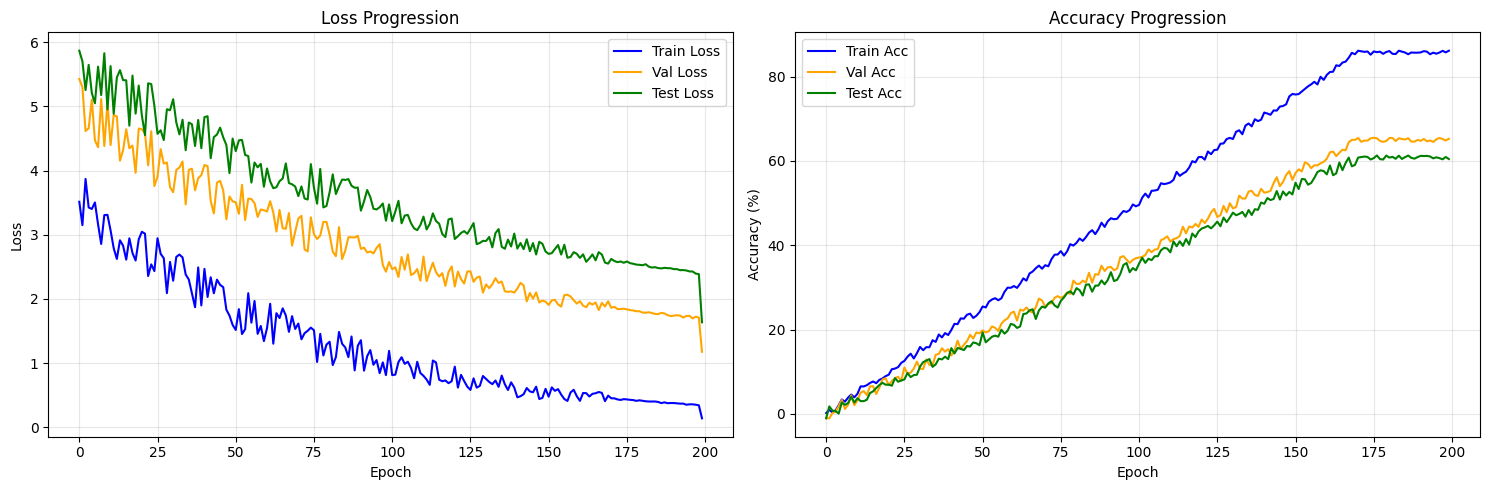

In [ ]:
# This code block integrates downloading a VQA dataset, preprocessing it, training a Visual Question Answering (VQA) model with stacked attention,
#   and running inference to predict answers for image-question pairs while providing functionalities like training visualization, interactive predictions, and cleanup.

import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms

class VQATrainer:
    def __init__(self, model, train_loader, val_loader, device, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config

        self.optimizer = config['optimizer'](
            model.parameters(),
            **config['optimizer_params']
        )

        self.scheduler = config['scheduler'](
            self.optimizer,
            total_steps=len(train_loader) * config.get('num_epochs', 100),
            **config['scheduler_params']
        )

        self.criterion = nn.CrossEntropyLoss()

        self.scaler = GradScaler()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1} [Train]')
        for batch in pbar:
            images = batch['image'].to(self.device)
            questions = batch['question_tokens'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            answers = batch['answer'].to(self.device)

            with autocast(enabled=self.config['mixed_precision']):
                outputs = self.model(images, questions, attention_mask)
                loss = self.criterion(outputs, answers)

            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()

            if self.config['gradient_clip_val'] > 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.config['gradient_clip_val']
                )

            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += answers.size(0)
            correct += predicted.eq(answers).sum().item()

            pbar.set_postfix({
                'loss': total_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })

        return total_loss / len(self.train_loader), 100. * correct / total

    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation'):
                images = batch['image'].to(self.device)
                questions = batch['question_tokens'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                answers = batch['answer'].to(self.device)

                outputs = self.model(images, questions, attention_mask)
                loss = self.criterion(outputs, answers)

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += answers.size(0)
                correct += predicted.eq(answers).sum().item()

        return total_loss / len(self.val_loader), 100. * correct / total

    def train(self, num_epochs, checkpoint_dir='checkpoints'):
        os.makedirs(checkpoint_dir, exist_ok=True)
        best_val_acc = 0

        for epoch in range(num_epochs):

            train_loss, train_acc = self.train_epoch(epoch)

            val_loss, val_acc = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_checkpoint(
                    os.path.join(checkpoint_dir, 'best_model.pth'),
                    epoch,
                    val_acc
                )

            self.save_checkpoint(
                os.path.join(checkpoint_dir, 'latest_model.pth'),
                epoch,
                val_acc
            )

    def save_checkpoint(self, path, epoch, val_acc):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_accuracy': val_acc,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies
        }, path)

    def plot_metrics(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Acc')
        plt.plot(self.val_accuracies, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

class VQAInference:
    def __init__(self, model_path, answer_vocab, device):
        self.device = device
        self.idx_to_answer = {idx: ans for ans, idx in answer_vocab.items()}

        checkpoint = torch.load(model_path, map_location=device)
        self.model = VQAModel(num_answers=len(answer_vocab))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model = self.model.to(device)
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def predict(self, image_path, question):
        """Make a prediction for a single image and question"""

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)

        encoded = self.tokenizer(
            question,
            padding='max_length',
            truncation=True,
            max_length=30,
            return_tensors='pt'
        )
        question_tokens = encoded['input_ids'].to(self.device)
        attention_mask = encoded['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(image, question_tokens, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            predicted = outputs.max(1)[1]
            confidence = probabilities.max(1)[0]

        answer = self.idx_to_answer[predicted.item()]
        return answer, confidence.item()

    def visualize_prediction(self, image_path, question):
        """Visualize image with question and predicted answer"""
        answer, confidence = self.predict(image_path, question)

        image = Image.open(image_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis('off')

        plt.title(f'Q: {question}\nA: {answer} (Confidence: {confidence:.2f})')
        plt.show()

if __name__ == "__main__":
    try:

        print("Step 1: Setting up data downloader...")
        downloader = VQADataDownloader()

        print("Step 2: Checking/downloading dataset...")
        downloader.download_complete_dataset()

        num_samples = int(input("\nEnter the number of samples to extract (e.g., 100): "))

        print(f"\nStep 4: Extracting {num_samples} samples...")
        filtered_questions, filtered_annotations = downloader.extract_samples(num_samples)

        print("\nStep 5: Processing data...")
        processor = VQAProcessor(downloader.local_dir)
        train_df, val_df, test_df, answer_vocab = processor.process_data(
            filtered_questions=filtered_questions,
            filtered_annotations=filtered_annotations
        )

        print("\nStep 6: Creating data module...")
        data_module = VQADataModule(
            data_dir=downloader.local_dir,
            batch_size=32,
            num_workers=2
        )
        data_module.setup()
        train_loader, val_loader, test_loader = data_module.get_dataloaders()

        print("\nStep 7: Initializing model...")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = VQAModel(num_answers=len(answer_vocab))
        model = model.to(device)
        model.unfreeze_top_layers()

        print("\nStep 8: Setting up training configuration...")
        config = get_training_config()
        config['num_epochs'] = 100

        print("\nStep 9: Starting training...")
        trainer = VQATrainer(model, train_loader, val_loader, device, config)
        trainer.train(num_epochs=config['num_epochs'])
        trainer.plot_metrics()

        print("\nStep 10: Setting up inference...")
        inference = VQAInference(
            model_path='checkpoints/best_model.pth',
            answer_vocab=answer_vocab,
            device=device
        )

        while True:
            image_path = input("\nEnter image path (or 'quit' to exit): ")
            if image_path.lower() == 'quit':
                break

            question = input("Enter your question: ")
            inference.visualize_prediction(image_path, question)

        # Step 12: Cleanup
        cleanup_response = input("\nDo you want to clean up local files? (y/n): ")
        if cleanup_response.lower() == 'y':
            downloader.cleanup()

    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

Using device: cpu


<ipython-input-10-d033b345d909>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)



Enter image path (or 'quit' to exit): /content/vqa_dataset/processed_images/COCO_train2014_000000042122.npy
Enter your question about the image: What is it?
Error processing image: cannot identify image file '/content/vqa_dataset/processed_images/COCO_train2014_000000042122.npy'

Enter image path (or 'quit' to exit): /content/vqa_dataset/train2014/COCO_train2014_000000042122.jpg
Enter your question about the image: What is it?


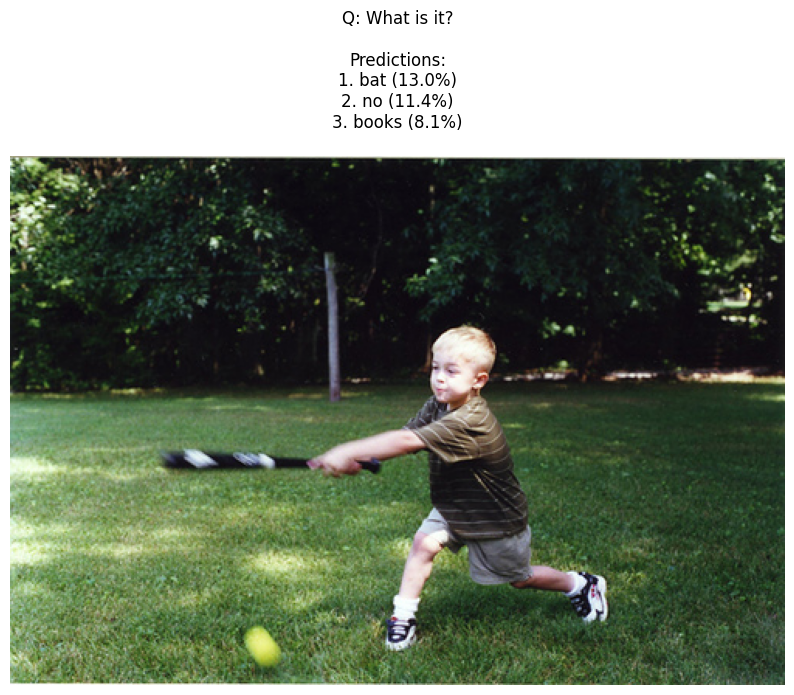


Top 3 Predictions:
1. bat (13.0%)
2. no (11.4%)
3. books (8.1%)


In [ ]:
#This code block implements a VQAPredictor class for Visual Question Answering (VQA), enabling predictions for given image-question pairs. It loads a pre-trained VQA model,
# processes images and questions, adjusts "yes" and "no" probabilities for enhanced interpretability, and visualizes predictions along with the image.
# It supports interactive usage and displays the top-3 predicted answers with confidence scores.

import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import BertTokenizer
import json

class VQAPredictor:
    def __init__(self, model_path, vocab_path, device=None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        print(f"Using device: {self.device}")

        with open(vocab_path, 'r') as f:
            self.answer_vocab = json.load(f)
            self.idx_to_answer = {idx: ans for ans, idx in self.answer_vocab.items()}

        self.model = VQAModel(num_answers=len(self.answer_vocab))

        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model = self.model.to(self.device)
        self.model.eval()

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def adjust_yes_no_probabilities(self, probabilities):
        """Adjust yes/no probabilities by boosting yes and reducing no"""
        yes_idx = None
        no_idx = None

        for idx, answer in self.idx_to_answer.items():
            if answer.lower() == 'yes':
                yes_idx = idx
            elif answer.lower() == 'no':
                no_idx = idx

        if yes_idx is not None and no_idx is not None:
            probabilities[0, yes_idx] *= 1.2  # Increase yes
            probabilities[0, no_idx] *= 0.7   # Decrease no

            probabilities = probabilities / probabilities.sum(dim=1, keepdim=True)

        return probabilities

    def predict(self, image_path, question, show_image=True):
        """Make a prediction for a given image and question"""
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)

        encoded = self.tokenizer(
            question,
            padding='max_length',
            truncation=True,
            max_length=30,
            return_tensors='pt'
        )

        question_tokens = encoded['input_ids'].to(self.device)
        attention_mask = encoded['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(image_tensor, question_tokens, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)

            probabilities = self.adjust_yes_no_probabilities(probabilities)

            top_k_probs, top_k_indices = torch.topk(probabilities, k=3, dim=1)

        predictions = []
        for probs, indices in zip(top_k_probs[0], top_k_indices[0]):
            answer = self.idx_to_answer[indices.item()]
            confidence = probs.item() * 100
            predictions.append((answer, confidence))

        if show_image:
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.axis('off')

            title = f"Q: {question}\n"
            title += "\nPredictions:\n"
            for i, (ans, conf) in enumerate(predictions, 1):
                title += f"{i}. {ans} ({conf:.1f}%)\n"

            plt.title(title)
            plt.show()

        return predictions

if __name__ == "__main__":
    predictor = VQAPredictor(
        model_path='checkpoints/best_model.pth',
        vocab_path='vqa_dataset/answer_vocab.json'
    )

    while True:
        image_path = input("\nEnter image path (or 'quit' to exit): ")
        if image_path.lower() == 'quit':
            break

        question = input("Enter your question about the image: ")

        try:
            predictions = predictor.predict(image_path, question)

            print("\nTop 3 Predictions:")
            for i, (answer, confidence) in enumerate(predictions, 1):
                print(f"{i}. {answer} ({confidence:.1f}%)")

        except Exception as e:
            print(f"Error processing image: {str(e)}")